# 0. Datenbankabfrage und Definition von Funktionen

In [1]:
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
np.seterr(all='ignore')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import mysql.connector
import psycopg2
pd.options.mode.chained_assignment = None
from IPython.display import display, Markdown, HTML

display(Markdown(f"### Letztes Update: {date.today()}"))

### Letztes Update: 2023-06-05

In [2]:
mysql_db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo",
    charset="latin1"
)

postgres_db = psycopg2.connect(
    database='kratos',
    host='localhost',
    user='serlo',
    password='secret')


def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(db, sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(mysql_db, sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

In [3]:
def read_event_log_edits():
    df = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username, event_parameter_uuid.uuid_id from event_log
        join user on user.id = event_log.actor_id
        join event_parameter on event_parameter.log_id = event_log.id
        join event_parameter_uuid on event_parameter_uuid.event_parameter_id = event_parameter.id
        where event_log.event_id = 5
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, mysql_db)
    df.set_index("id", inplace=True)
    df.rename(columns={"uuid_id": "uuid"}, inplace=True)
    df["subject"] = df["uuid"].map(getSubjectFromUuid)
    return df

event_log_edits = read_event_log_edits()

interest_df = pd.DataFrame(query(postgres_db, "SELECT traits ->> 'username', (metadata_public ->> 'legacy_id')::int, traits ->> 'interest' FROM identities;"), columns=['username', 'legacy_id', 'interest'])

merged_df_edits = pd.merge(event_log_edits, interest_df, left_on="actor_id", right_on="legacy_id").drop(["legacy_id", "username_y"], axis=1).rename(columns={'username_x': 'username'})

In [4]:
def get_number_of_all_authors(days=90, edits=10, week=0, year=0, days2=0, interest="all", subject="all"):
    
    lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + days2 + week*7 + year*365)
    upper_date = pd.Timestamp.today() - pd.Timedelta(days = days2 + week*7 + year*365)

    df2 = merged_df_edits[ (lower_date < merged_df_edits['date'])  &  (upper_date > merged_df_edits['date'])  ] 
    
    if interest == "teacher":
        df2 = df2.loc[df2['interest'].isin(['teacher'])]
    elif interest == "no teachers":
        df2 = df2.loc[df2['interest'].isin([''])]
        
    if subject != "all":
        df2 = df2.loc[df2['subject'].isin([subject])]
    
    df2 = df2.reset_index()
    df3 = df2.groupby(by = ['actor_id', 'username'], as_index = False).count()
    #Delete all authors under baseline
    df4 = df3
    df4['isActive'] = df4['uuid'].apply(lambda x: 1 if x >= edits else 0)
    
    
    return df4[df4.isActive == 1].actor_id.count()

In [5]:
def get_number_of_all_edits(days=90, edits=1, week=0, year=0, days2=0, interest="all", subject="all"):
    
    lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + days2 + week*7 + year*365)
    upper_date = pd.Timestamp.today() - pd.Timedelta(days = days2 + week*7 + year*365)

    df2 = merged_df_edits[ (lower_date < merged_df_edits['date'])  &  (upper_date > merged_df_edits['date'])  ] 
    
    if interest == "teacher":
        df2 = df2.loc[df2['interest'].isin(['teacher'])]
    elif interest == "no teachers":
        df2 = df2.loc[df2['interest'].isin([''])]
        
    if subject != "all":
        df2 = df2.loc[df2['subject'].isin([subject])]
    
    df2 = df2.reset_index()
    
    df3 = df2.groupby(by = ['actor_id', 'username'], as_index = False).count()
    #Delete all authors under baseline
    df4 = df3
    df4['isActive'] = df4['uuid'].apply(lambda x: 1 if x >= edits else 0)
    
    df2 = df2[df2["actor_id"].isin(df4[df4.isActive == 1].actor_id)]
    
    return df2.actor_id.count()

In [6]:
def get_one_year_dates(days=365, year1=0, year2=0):
    
    lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + year1*365 +year2*365)
    upper_date = pd.Timestamp.today() - pd.Timedelta(days = year2*365)
    
    one_year_dates = []
    current_date = lower_date + relativedelta(days=1)
    
    while current_date <= upper_date:
        one_year_dates.append(current_date)
        current_date += relativedelta(days=1)
        
    return one_year_dates

def new_range(days=365):
    return list(reversed(range(days)))

In [7]:
event_log_contents = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username from event_log
        join user on user.id = event_log.actor_id
        where event_log.event_id = 4
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, mysql_db)

# Join for getting the interest
merged_df_contents = pd.merge(event_log_contents, interest_df, left_on="actor_id", right_on="legacy_id").drop(["legacy_id", "username_y"], axis=1).rename(columns={"username_x": "username"})

In [8]:
def get_number_of_created_contents(days=90, edits=1, week=0, year=0, days2=0, interest="all"):
    
    lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + days2 + week*7 + year*365)
    upper_date = pd.Timestamp.today() - pd.Timedelta(days = days2 + week*7 + year*365)

    df2 = merged_df_contents[(lower_date < merged_df_contents['date'])  &  (upper_date > merged_df_contents['date'])]
    
    if interest == "teacher":
        df2 = df2.loc[df2['interest'].isin(['teacher'])]
    elif interest == "no teachers":
        df2 = df2.loc[df2['interest'].isin([''])]
    
    df2 = df2.reset_index()
    
    df3 = df2.groupby(by = ['actor_id', 'username'], as_index = False).count()
    #Delete all authors under baseline
    df4 = df3
    df4['isActive'] = df4['id'].apply(lambda x: 1 if x >= edits else 0)
    
    df2 = df2[df2["actor_id"].isin(df4[df4.isActive == 1].actor_id)]
    
    return df2.actor_id.count()

In [9]:
def get_top_authors(days=90, week=0, year=0, days2=0, interest="all", subject="all", top=10):
    
    lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + days2 + week*7 + year*365)
    upper_date = pd.Timestamp.today() - pd.Timedelta(days = days2 + week*7 + year*365)

    df2 = merged_df_edits[ (lower_date < merged_df_edits['date'])  &  (upper_date > merged_df_edits['date'])  ] 
    
    if interest == "teacher":
        df2 = df2.loc[df2['interest'].isin(['teacher'])]
    elif interest == "no teachers":
        df2 = df2.loc[df2['interest'].isin([''])]
          
    if subject != "all":
        df2 = df2.loc[df2['subject'].isin([subject])]

    df2 = df2.reset_index()    
        
    df3 = df2.groupby(by = ['username'], as_index=False)["index"].count()
    df3.rename(columns={"index": "edits"}, inplace=True)
    df3 = df3.sort_values(by=['edits'], ascending=[False])
    df3 = df3.reset_index()
    df3 = df3.drop(columns=["index"])
    
    df_top = df3.head(top)
    sum_of_others = df3.iloc[top:, 1].sum()
    df_combined = df_top.append({'username': 'others', 'edits': sum_of_others}, ignore_index=True)
    df_combined = df_combined.sort_values(by=['edits'], ascending=[False])
    
    return df_combined

In [10]:
def create_kpi_table():
    index = pd.MultiIndex.from_product([['all authors', 'active authors', 'very active authors'],
                                     ['all', 'teacher', 'no teacher']]
                                    )
    kpi_df = pd.DataFrame(index=index, columns=[])

    number_of_authors_column = []
    for edits in (1, 10, 100):
        for interest in ("all", "teacher", "no teachers"):
            number_of_authors_column.append(get_number_of_all_authors(days=90, edits=edits, interest=interest))

    kpi_df["number of authors"] = number_of_authors_column

    last_year_column = []
    for edits in (1, 10, 100):
        for interest in ("all", "teacher", "no teachers"):
            last_year_column.append(get_number_of_all_authors(days=90, year=1, edits=edits, interest=interest))

    kpi_df["last year"] = last_year_column

    percent_change_column = []
    for edits in (1, 10, 100):
        for interest in ("all", "teacher", "no teachers"):
            percent_change_column.append(
                (get_number_of_all_authors(days=90, year=0, edits=edits, interest=interest) -
                 get_number_of_all_authors(days=90, year=1, edits=edits, interest=interest)) /
                get_number_of_all_authors(days=90, year=1, edits=edits, interest=interest)
            )

    kpi_df["% change"] = percent_change_column

    kpi_df["% change"] = kpi_df["% change"] * 100
    kpi_df["% change"] = kpi_df["% change"].fillna(0).round().astype(int)

    edits_column = []
    for edits in (1, 10, 100):
        for interest in ("all", "teacher", "no teachers"):
            edits_column.append(get_number_of_all_edits(days=90, edits=edits, interest=interest))

    kpi_df["edits"] = edits_column

    last_year_column = []
    for edits in (1, 10, 100):
        for interest in ("all", "teacher", "no teachers"):
            last_year_column.append(get_number_of_all_edits(days=90, year=1, edits=edits, interest=interest))

    kpi_df["last_year"] = last_year_column

    percent_change_column = []
    for edits in (1, 10, 100):
        for interest in ("all", "teacher", "no teachers"):
            percent_change_column.append(
                (get_number_of_all_edits(days=90, year=0, edits=edits, interest=interest) -
                 get_number_of_all_edits(days=90, year=1, edits=edits, interest=interest)) /
                get_number_of_all_edits(days=90, year=1, edits=edits, interest=interest)
            )

    kpi_df["%_change"] = percent_change_column

    kpi_df["%_change"] = kpi_df["%_change"] * 100
    kpi_df["%_change"] = kpi_df["%_change"].fillna(0).round().astype(int)

    created_contents_column = []
    for edits in (1, 10, 100):
        for interest in ("all", "teacher", "no teachers"):
            created_contents_column.append(get_number_of_created_contents(days=90, edits=edits, interest=interest))

    kpi_df["created contents"] = created_contents_column

    last_year_column = []
    for edits in (1, 10, 100):
        for interest in ("all", "teacher", "no teachers"):
            last_year_column.append(get_number_of_created_contents(days=90, year=1, edits=edits, interest=interest))

    kpi_df["last._year"] = last_year_column

    percent_change_column = []
    for edits in (1, 10, 100):
        for interest in ("all", "teacher", "no teachers"):
            percent_change_column.append(
                (get_number_of_created_contents(days=90, year=0, edits=edits, interest=interest) -
                 get_number_of_created_contents(days=90, year=1, edits=edits, interest=interest)) /
                get_number_of_created_contents(days=90, year=1, edits=edits, interest=interest)
            )

    kpi_df["%._change"] = percent_change_column

    kpi_df["%._change"] = kpi_df["%._change"] * 100
    kpi_df["%._change"] = kpi_df["%._change"].fillna(0).round().astype(int)

    # creating conditional formatting rules

    def get_color(val):
        color_map = {
            100: "#089C33",
            75: "#0ABF3E",
            50: "#0CD044",
            25: "#72ED96",
            1: "#BFF1CE",
            -0.9: "#E8F1EB",
            -25: "#F6D9CD",
            -50: "#F67740",
            -75: "#D76A3A",
            -100: "#B1562F",
        }

        for threshold, color in color_map.items():
            if val >= threshold:
                return color

        return "#884324"

    standard_color = ['white', '#D6EAF8'] * 8
    number_of_authors_color = [get_color(kpi_df['% change'][i]) for i in range(9)]
    number_of_edits_color = [get_color(kpi_df['%_change'][i]) for i in range(9)]
    number_of_contents_color = [get_color(kpi_df['%._change'][i]) for i in range(9)]

    header_list = ["", "", "<b>Anzahl Autor*innen<b>", "letztes<br>Jahr", "% Veränderung", "<b>Anzahl Bearbeitungen<b>",
                   "letztes<br>Jahr", "% Veränderung", "<b>Anzahl erstellte Inhalte<b>", "letztes<br>Jahr",
                   "% Veränderung"]

    # creating kpi_table

    fig = go.Figure(data=[go.Table(
        header=dict(values=header_list,
                    fill_color='darkblue',
                    font_color='white',
                    align='center',
                    line_color="grey"),
        cells=dict(
            values=[["<b>alle Autor*innen<b>", "", "", "<b>aktive Autor*innen<b>", "", "", "<b>sehr aktive Autor*innen<b>",
                     "", ""],
                    ["alle", "Lehrer*innen", "keine Lehrer*innen"] * 3,
                    kpi_df['number of authors'],
                    kpi_df['last year'],
                    kpi_df['% change'],
                    kpi_df['edits'],
                    kpi_df['last_year'],
                    kpi_df['%_change'],
                    kpi_df['created contents'],
                    kpi_df['last._year'],
                    kpi_df['%._change']],
            height=40,
            fill_color=[standard_color] * 4 + [number_of_authors_color] + [standard_color] * 2
                       + [number_of_edits_color] + [standard_color] * 2 + [number_of_contents_color],
            line_color="grey"
        )

    )],
    )

    fig.update_layout(height=700, width=1200, title='KPIs kumuliert über die letzten 90 Tage', title_x=0.5,
                     title_font=dict(size=24),)

    fig.show(renderer="png")

In [20]:
def create_kpi_figure(title, get_value_func, split='activity'):
    
    split_mapping = {
        'activity': [['alle', 'aktive', 'sehr aktive'], [1, 10, 100], ['all', 'all', 'all']],
        'interest': [['alle', 'Lehrer*innen', 'keine Lehrer*innen'],  [1, 1, 1], ['all', 'teacher', 'no teachers']]
    }
    
    fig = make_subplots(rows=1, cols=3, subplot_titles=('KPI 1', 'KPI 2', 'KPI 3'), specs=[[{"type": "indicator"}] * 3],
                        horizontal_spacing=0.2)
    annotations = []

    
    
    def add_kpi_card(fig, annotations, title, value, last_year_value, row, col):
        col_mapping = {1: 0.1, 2: 0.5, 3: 0.9}

        annotations.append(
            go.layout.Annotation(
                text=f"letztes Jahr: {last_year_value}",
                x=col_mapping.get(col),
                y=-0.15,
                showarrow=False,
                font=dict(size=25, color="black")
            )
        )

        fig.add_trace(go.Indicator(
            mode="number+delta",
            value=value,
            delta={"reference": last_year_value, "font": {"size": 25}},
            title={'text': title, "font": {"color": "black"}},
            number={'valueformat': ',d', "font": {"color": "black"}},
        ), row=row, col=col)

    for i in range(3):
        add_kpi_card(fig, annotations, split_mapping.get(split)[0][i], 
                 get_value_func(edits=split_mapping.get(split)[1][i], interest=split_mapping.get(split)[2][i]),
                 get_value_func(edits=split_mapping.get(split)[1][i], interest=split_mapping.get(split)[2][i], year=1), 1, i+1)

    fig.update_layout(
        title={
            'text': title,
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=26, color='black')
        },
        annotations=annotations,
        height=400,
        width=1000,
        paper_bgcolor='#D6EAF8',
    )

    for i in [.7, .3]:
        fig.add_shape(
            type="rect",
            x0=i - 0.008, y0=-.5, x1=i + 0.008, y1=1.13,
            line=dict(color='white', width=3),
            fillcolor='white',
            layer="below",
            opacity=1
        )

    fig.add_shape(type="rect", x0=-.1, x1=1.1, y0=1.13, y1=1.17,
                  line=dict(color='white', width=3),
                  fillcolor='white')

    fig.show(renderer="png")

In [28]:
def create_time_chart(title, get_data_func, split):
    
    if split == "interest":
        y = [
              [get_data_func(days2=i, edits=1) for i in new_range(days=365*4)],
              [get_data_func(days2=i, edits=1, interest="teacher") for i in new_range(days=365*4)],
              [get_data_func(days2=i, edits=1, interest="no teacher") for i in new_range(days=365*4)]
          ] 
        
        new_labels = {'wide_variable_0':'alle Autor*innen', 
              'wide_variable_1': 'Lehrer*innen',
             'wide_variable_2': 'keine Lehrer*innen'}
        
    elif split == "activity":
        y = [
              [get_data_func(days2=i, edits=1) for i in new_range(days=365*4)],
              [get_data_func(days2=i, edits=10) for i in new_range(days=365*4)],
              [get_data_func(days2=i, edits=100) for i in new_range(days=365*4)]
          ]
        
        new_labels = {'wide_variable_0':'alle Autor*innen', 
              'wide_variable_1': 'aktive Autor*innen',
             'wide_variable_2': 'sehr aktive Autor*innen'}  
            
    fig = px.line(x=get_one_year_dates(days=365*4),
                     y=y,
                     title=title)
    fig.update_layout(title={'text': title,
                             'x':0.5},
                    plot_bgcolor='#ECF2FF', 
                     paper_bgcolor='#ECF2FF', 
                     height=400, width=1000,
                     legend_title = None,
                    xaxis_title=None,
                     yaxis_title=None)
    fig.for_each_trace(lambda t: t.update(name = new_labels[t.name]))

    fig.show(renderer="png")
    

In [29]:
def create_share_graph(get_data_func, split):
    
    if split == "interest":
        
        None
        
    elif split == "activity":
        
        label_mapping = {
            get_number_of_all_edits: ['Anteil an Bearbeitungen'],
            get_number_of_created_contents: ['Anteil an erstellten Inhalten']
        }
        
    
    fig = go.Figure()

    fig.add_trace(go.Bar(x=['Anteil Autor*innen'], y=[((get_number_of_all_authors(edits=1)-
                                                        get_number_of_all_authors(edits=10))*100)/
                                             get_number_of_all_authors(edits=1)], name="andere",
                         marker_color='lightgray'))

    fig.add_trace(go.Bar(x=['Anteil Autor*innen'], y=[((get_number_of_all_authors(edits=10)-
                                                        get_number_of_all_authors(edits=100))*100)/
                                             get_number_of_all_authors(edits=1)], name='aktive Autor*innen',
                         marker_color='lightblue'))

    fig.add_trace(go.Bar(x=['Anteil Autor*innen'], y=[(get_number_of_all_authors(edits=100)*100)/
                                             get_number_of_all_authors(edits=1)], name='sehr aktive Autor*innen',
                         marker_color='pink'))


    fig.add_trace(go.Bar(x=label_mapping.get(get_data_func), y=[((get_data_func(edits=1)-
                                                            get_data_func(edits=10)) *100)/
                                             get_data_func(edits=1)], name="andere",
                         marker_color='lightgray', showlegend=False))

    fig.add_trace(go.Bar(x=label_mapping.get(get_data_func), y=[((get_data_func(edits=10)-
                                                            get_data_func(edits=100)) *100)/
                                             get_data_func(edits=1)], name='aktive Autor*innen',
                         marker_color='lightblue', showlegend=False))

    fig.add_trace(go.Bar(x=label_mapping.get(get_data_func), y=[(get_data_func(edits=100)*100)/
                                             get_data_func(edits=1)], name='sehr aktive Autor*innen',
                         marker_color='pink', showlegend=False))


    fig.update_traces(texttemplate='%{y:.0f}%', textposition='inside')


    fig.update_layout(title='Anteil aktiver und sehr aktiver Autor*innen',
                      title_x=0.5,
                      barmode='stack',
                      height=550,
                      width=1000,
                      plot_bgcolor='#ECF2FF', 
                      paper_bgcolor='#ECF2FF'
                     )

    fig.show(renderer="png")   

In [30]:
def create_top_author_chart(year=0):
    
    title_mapping = {0: 'aktive Autor*Innen aktuell', 1: 'aktive Autor*Innen vor einem Jahr'}
    
    fig = px.bar(get_top_authors(year=year), x='username', y='edits')
    fig.update_layout(title_x=0.5, height=550, width=1000)
    fig.show(renderer='png')   

# 1. Überblick

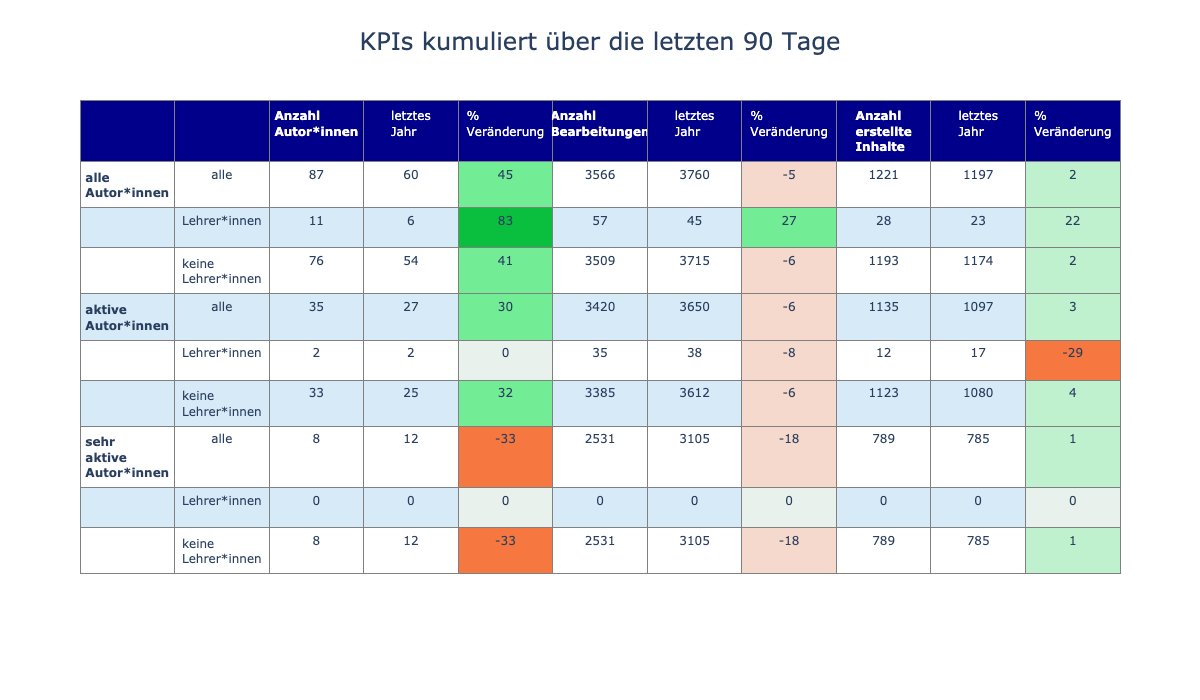

In [31]:
create_kpi_table()

# 2. Anzahl Autor*innen

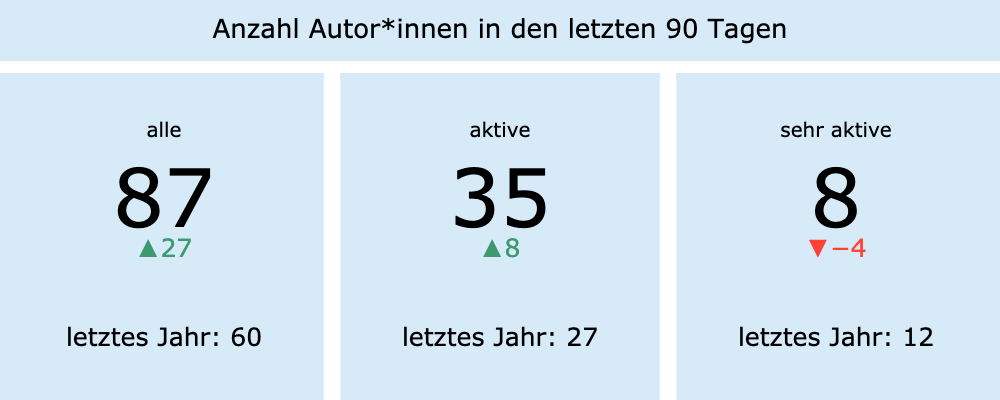

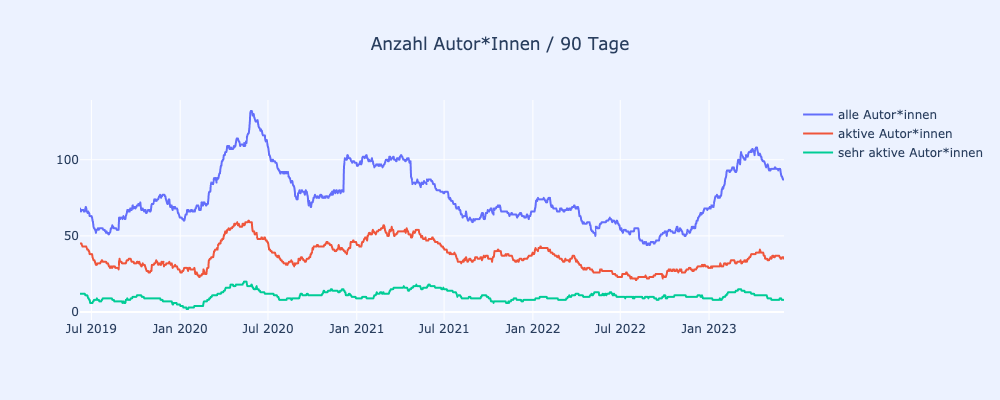

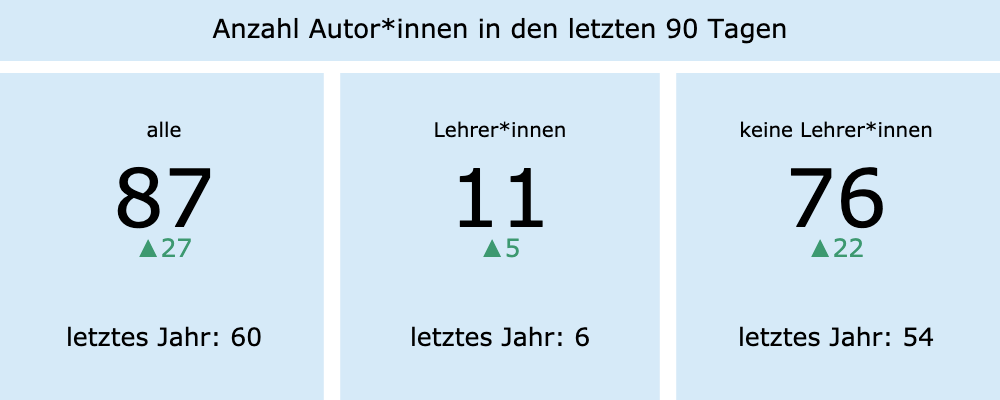

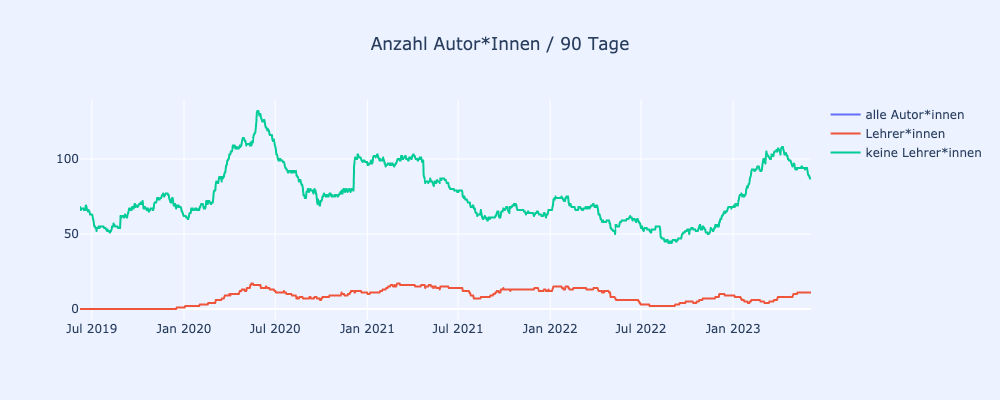

In [26]:
create_kpi_figure('Anzahl Autor*innen in den letzten 90 Tagen', get_number_of_all_authors)
create_time_chart(title="Anzahl Autor*Innen / 90 Tage", get_data_func=get_number_of_all_authors, split="activity")
create_kpi_figure('Anzahl Autor*innen in den letzten 90 Tagen', get_number_of_all_authors, split='interest')
create_time_chart(title="Anzahl Autor*Innen / 90 Tage", get_data_func=get_number_of_all_authors, split="teacher")

# 3. Anzahl Bearbeitungen

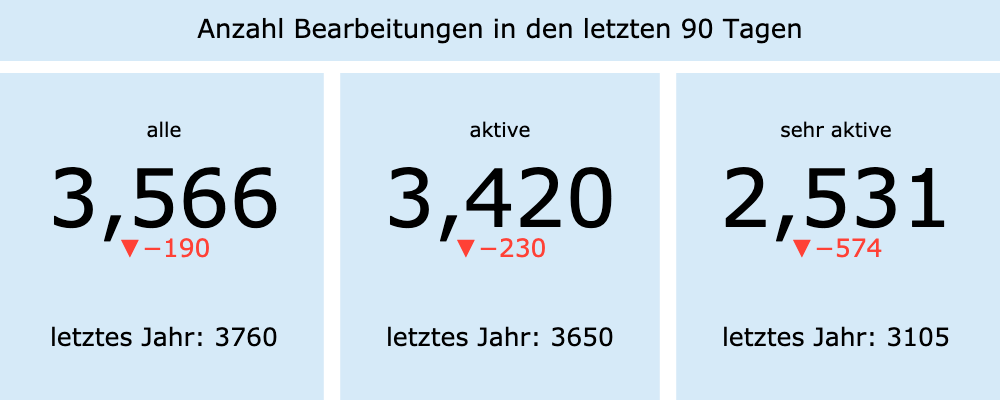

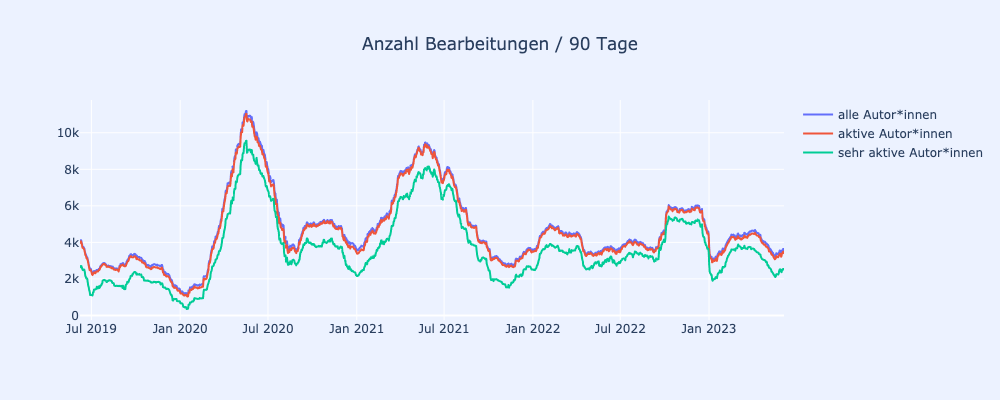

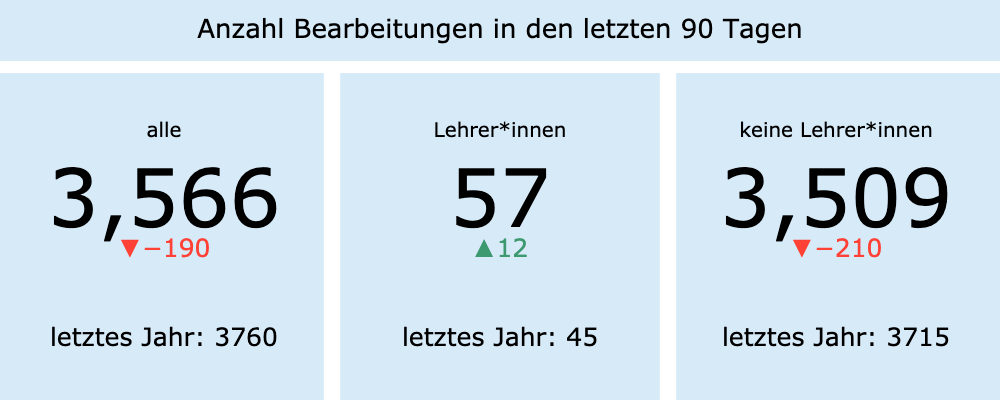

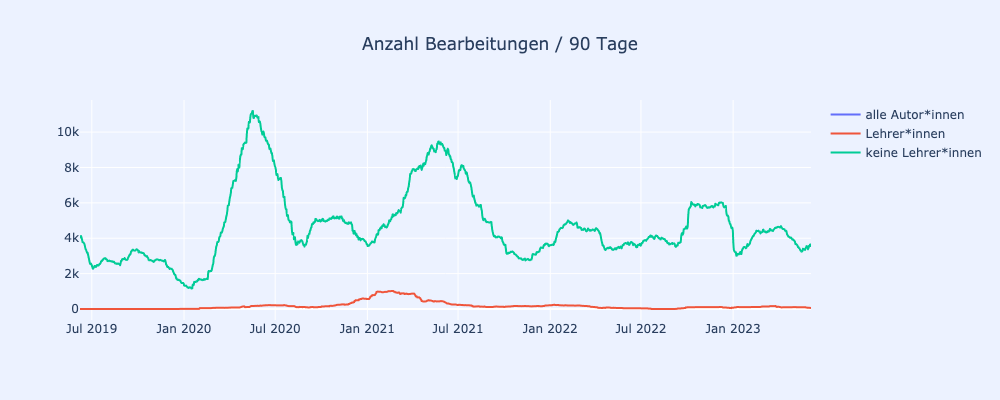

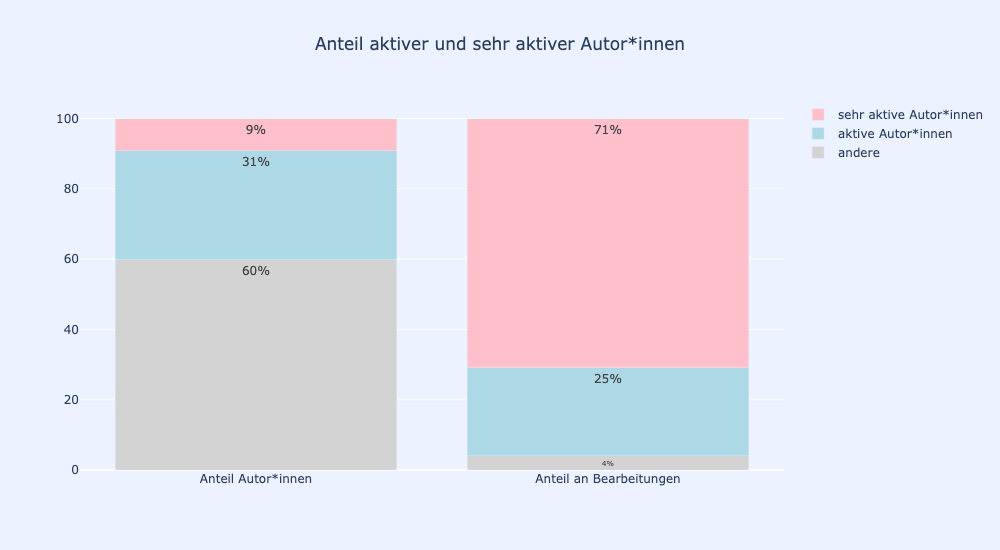

## 9% sehr aktive Autor*innen sind für 71% aller Bearbeitungen verantwortlich.

# Top Autor*Innen

,username,edits
10,others,848
0,Felix_Eccardt,614
1,Sascha_Lill_95,486
2,Kowalsky,436
3,Karin,290
4,metzgaria,242
5,Nadine_Gabel,221
6,Peter,131
7,Corinna,111
8,Julian1492,98


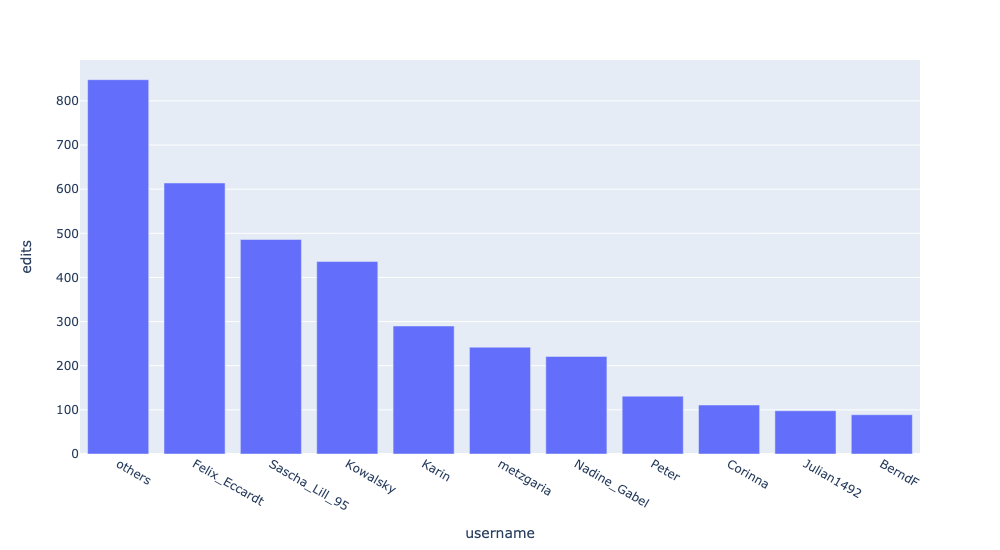

# Top Autor*Innen vor einem Jahr

,username,edits
10,others,865
0,Felix_Eccardt,720
1,LinaMaria,434
2,Kowalsky,425
3,Selin_11,331
4,Karin,254
5,metzgaria,187
6,kathongi,157
7,Annika-Hemlein,145
8,RalfReinecke,129


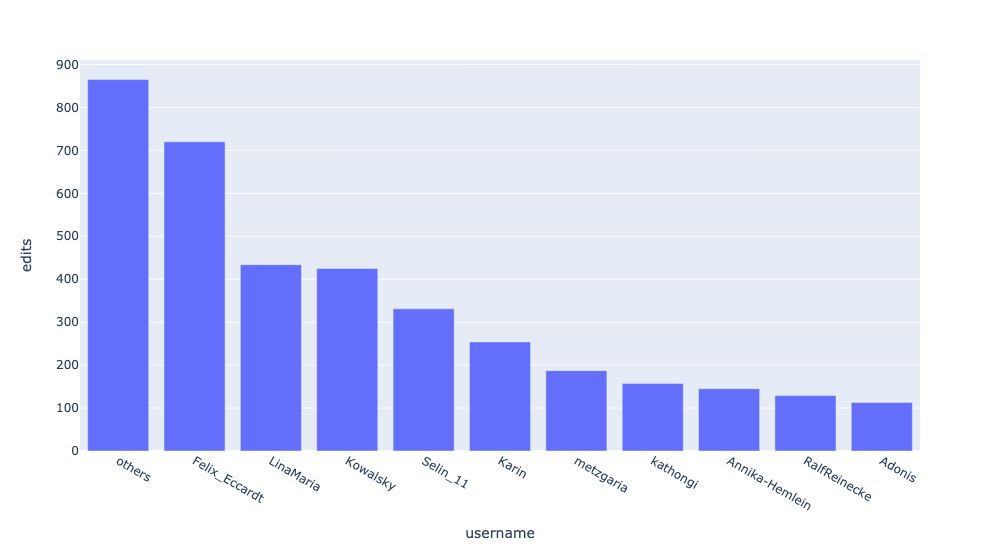

In [33]:
create_kpi_figure('Anzahl Bearbeitungen in den letzten 90 Tagen', get_number_of_all_edits)
create_time_chart(title="Anzahl Bearbeitungen / 90 Tage", get_data_func=get_number_of_all_edits, split="activity")
create_kpi_figure('Anzahl Bearbeitungen in den letzten 90 Tagen', get_number_of_all_edits, split='interest')
create_time_chart(title="Anzahl Bearbeitungen / 90 Tage", get_data_func=get_number_of_all_edits, split="interest")
create_share_graph(get_data_func=get_number_of_all_edits, split='activity')
display(Markdown(f'## {round((get_number_of_all_authors(edits=100)*100)/get_number_of_all_authors(edits=1))}% sehr aktive Autor*innen sind für {round((get_number_of_all_edits(edits=100)*100)/get_number_of_all_edits(edits=1))}% aller Bearbeitungen verantwortlich.'))
display(Markdown("# Top Autor*Innen"))
display(get_top_authors())
create_top_author_chart()
display(Markdown("# Top Autor*Innen vor einem Jahr"))
display(get_top_authors(year=1))
create_top_author_chart(year=1)

# 4. erstellte Inhalte

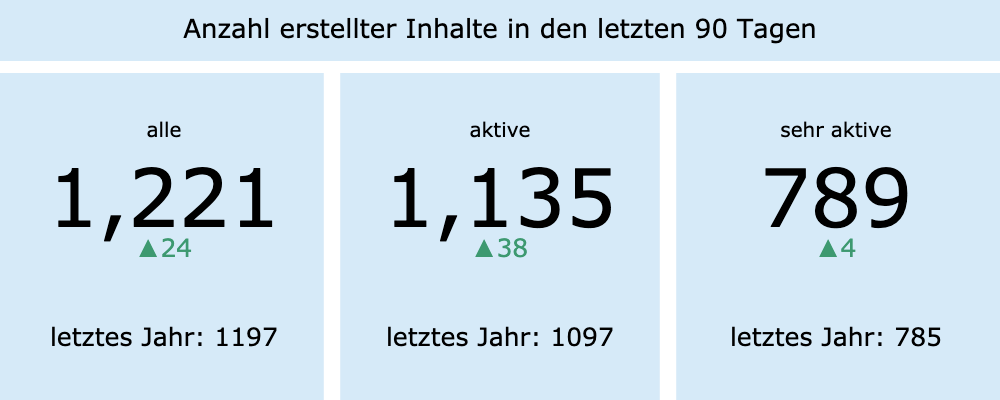

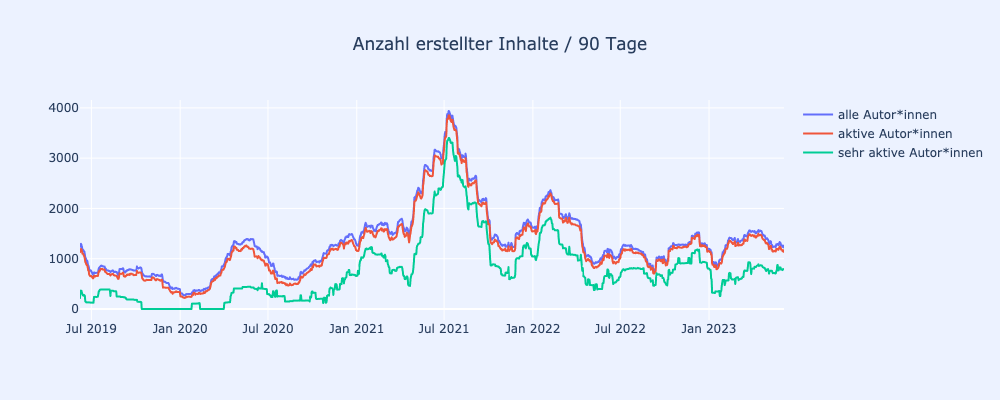

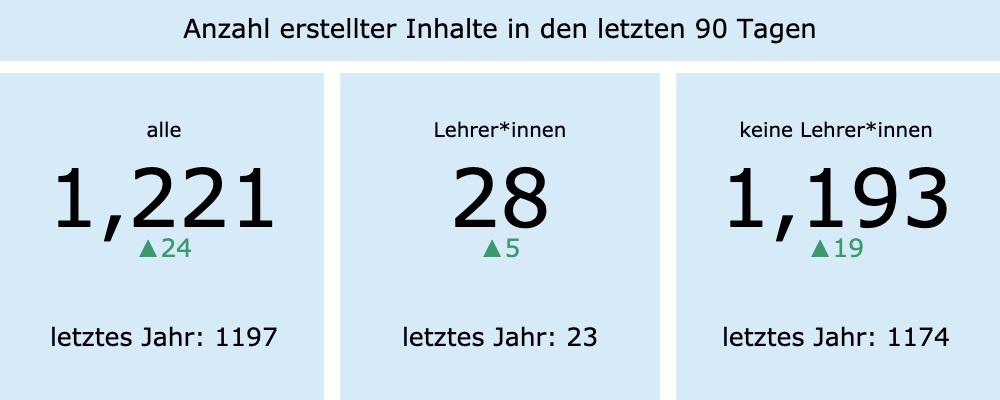

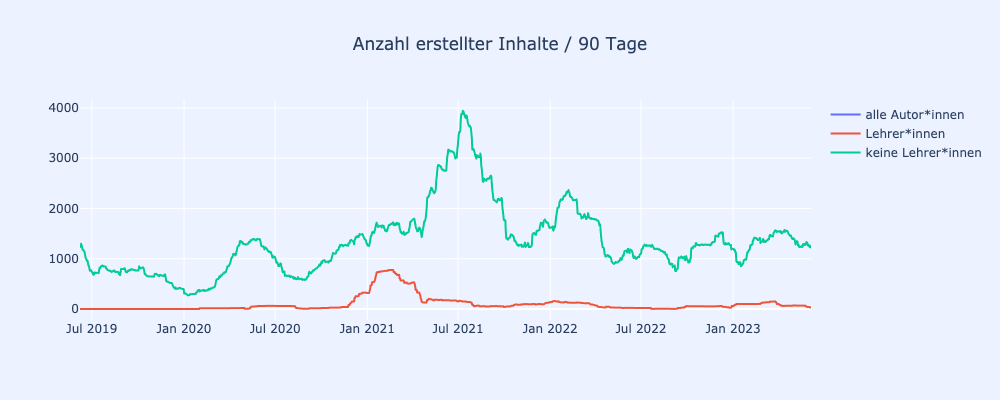

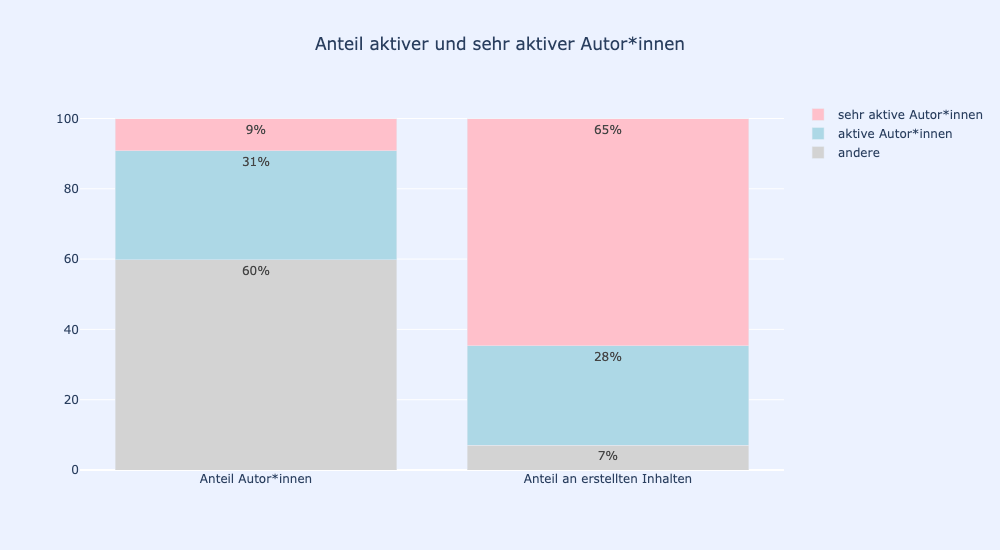

In [34]:
create_kpi_figure('Anzahl erstellter Inhalte in den letzten 90 Tagen', get_number_of_created_contents)
create_time_chart(title="Anzahl erstellter Inhalte / 90 Tage", get_data_func=get_number_of_created_contents, split="activity")
create_kpi_figure('Anzahl erstellter Inhalte in den letzten 90 Tagen', get_number_of_created_contents, split='interest')
create_time_chart(title="Anzahl erstellter Inhalte / 90 Tage", get_data_func=get_number_of_created_contents, split="interest")
create_share_graph(get_data_func=get_number_of_created_contents, split='activity')

# 4. Kollaboration

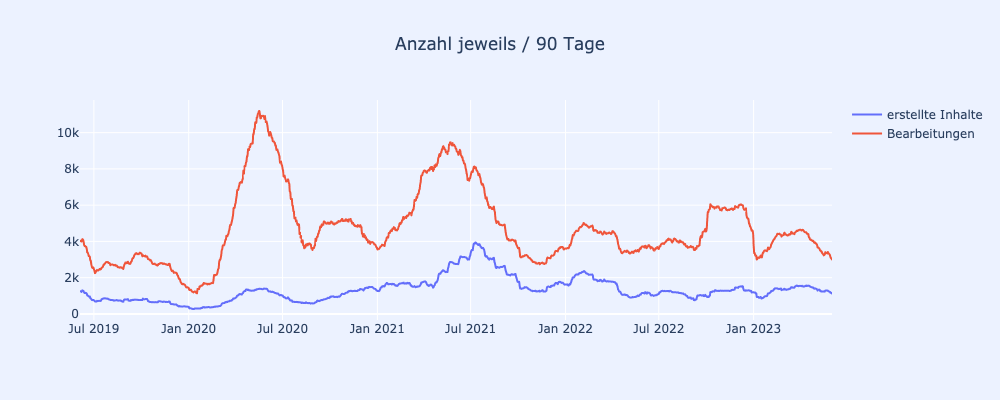

In [56]:
var_1 = [get_number_of_created_contents(days2=i, edits=1) for i in new_range(days=365*4)]
var_2 = [get_number_of_all_edits(days2=i, edits=1) for i in new_range(days=365*4)]


figure = px.line(x=get_one_year_dates(days=365*4),
                     y=[var_1, var_2],
                     title='Anzahl Autor*Innen / 90 Tage')
figure.update_layout(title={'text': 'Anzahl jeweils / 90 Tage',
                             'x':0.5},
                    plot_bgcolor='#ECF2FF', 
                     paper_bgcolor='#ECF2FF', 
                     height=400, width=1000,
                     legend_title = None,
                    xaxis_title=None,
                     yaxis_title=None)
new_labels = {'wide_variable_0':'erstellte Inhalte', 
              'wide_variable_1': 'Bearbeitungen'}
figure.for_each_trace(lambda t: t.update(name = new_labels[t.name]))
figure.show(renderer="png")

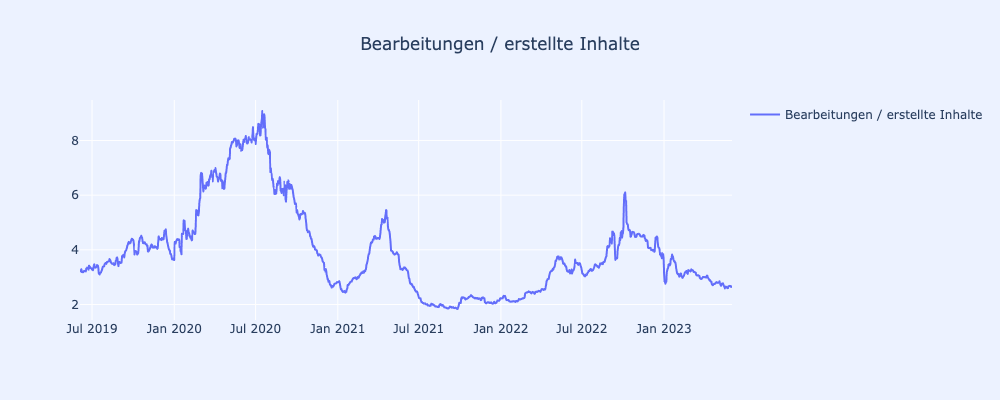

In [57]:
var_1 = [get_number_of_all_edits(days2=i, edits=1) / 
         get_number_of_created_contents(days2=i, edits=1) for i in new_range(days=365*4)]


figure = px.line(x=get_one_year_dates(days=365*4),
                     y=[var_1],
                     title='Anzahl Autor*Innen / 90 Tage')
figure.update_layout(title={'text': 'Bearbeitungen / erstellte Inhalte',
                             'x':0.5},
                    plot_bgcolor='#ECF2FF', 
                     paper_bgcolor='#ECF2FF', 
                     height=400, width=1000,
                     legend_title = None,
                    xaxis_title=None,
                     yaxis_title=None)
new_labels = {'wide_variable_0':'Bearbeitungen / erstellte Inhalte'}
figure.for_each_trace(lambda t: t.update(name = new_labels[t.name]))
figure.show(renderer="png")